# 📘 IMPLEMENTASI DATA STATIS REALTIME

## 📗 FEATURE ENGINEERING FUNCTION

In [7]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [8]:
import tensorflow as tf
print(tf.__version__)


2.19.0


In [9]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[0], 'GPU')


In [ ]:
def normalisasi2(data):
    vektor = [(d-data[0] )*100 for d in data[1:] ]
    return vektor
def normalisasi(data):
    dmin, dmax = np.min(data), np.max(data)
    return (data - dmin)
def scale_points(points, new_x_max):
    """
    Melakukan transformasi skala pada kumpulan titik berdasarkan nilai maksimum baru untuk sumbu X.
    
    Parameters:
        points (numpy.ndarray): Array 2D berisi koordinat titik, dengan kolom pertama sebagai X dan kedua sebagai Y.
        new_x_max (float): Nilai maksimum baru untuk sumbu X setelah transformasi.
        
    Returns:
        numpy.ndarray: Array 2D dari titik yang telah ditransformasi.
    """
    # Nilai maksimum awal untuk X
    x_max_original = np.max(points[:, 0])
    
    # Hitung skala
    scale = new_x_max / x_max_original
    
    # Transformasi titik berdasarkan skala
    transformed_points = (points * scale)
    
    return transformed_points[:,0],transformed_points[:,1]
    
    
    

[ WARN:28@691.479] global cap_v4l.cpp:1048 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.
[ WARN:29@691.483] global cap_v4l.cpp:1048 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.


## 📗 INISIASI VARIABEL ATAU DATA YANG DIBUTUHKAN

In [12]:
import tensorflow as tf
label_map={
  0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g',
  7: 'h', 8: 'i', 9: 'k', 10: 'l', 11: 'm', 12: 'n',
  13: 'o', 14: 'p', 15: 'q', 16: 'r', 17: 's',
  18: 't', 19: 'u', 20: 'v', 21: 'w', 22: 'x', 23: 'y'
}
column_numbers = [5,1,9,10,12,13,15,16,17,20,4,6,7,8,11,16,17]  # Ganti dengan indeks kolom yang diinginkan
column_numbersY = [2,3,4,7,9,10,11,12,15,19,20,16,17]

model = tf.keras.models.load_model("model/model_s_L2.h5")


## 📗 REALTIME IMPLEMENTATION WITHOUT THREADING

WITHOUT THREADING

In [13]:
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np
from collections import deque
import tensorflow as tf

# ==================== SETUP ====================

# Load model
model = tf.keras.models.load_model("model/model_static_filter.h5")

# Cek input shape model
# input_shape = model.input_shape  # (None, 35, 21)

# x_coor = [0,1,3,4,5,7,9,11,12,14,15,17,19,21]
# y_coor = [0,1,3,4,11,12]
# Mapping label

# MediaPipe setup
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(
    base_options=base_options,
    num_hands=1,
    running_mode=vision.RunningMode.IMAGE
)
detector = vision.HandLandmarker.create_from_options(options)

# Inisialisasi deque untuk menyimpan fitur dari frame sebelumnya


# Buka video
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Gagal membuka video.")
    exit()
# ==================== LOOP VIDEO FRAME ====================
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocessing untuk MediaPipe
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
    result = detector.detect(mp_image)

    label_text = "Menunggu 35 frame..."

    if result.hand_landmarks:
        for hand in result.hand_landmarks:
            features = []
            x_coor = []
            y_coor = []
            for idx, landmark in enumerate(hand):
                # features.append(landmark.x) 
                # if idx in [0,1,3,4,5,7,9,11,12,14,15,17,19,21]:
                #     x_coor.append(landmark.x)
                # if idx in [0,1,3,4,11,12]:
                #     y_coor.append(landmark.y)
                nilai_X = np.array([landmark.x for landmark in hand])
                nilai_Y = np.array([landmark.y for landmark in hand])
                nilai_Z = [np.array([landmark.y for landmark in hand])[0]]
                newX = normalisasi(nilai_X,(np.max(nilai_X)-np.min(nilai_X))) 
                newY = normalisasi(nilai_Y,(np.max(nilai_Y)-np.min(nilai_Y)))
                newXY = np.column_stack((newX, newY) )  # Simpan dalam list koordinat int
                newX , newY = scale_points(newXY,10)
                fiturX = newX[column_numbers]
                fiturY = newY[column_numbersY]
                features = np.concatenate((fiturX, fiturY,nilai_Z))
          
         
            k=np.array([features])
            prediction = model.predict(k, verbose=0)
            predicted_class = np.argmax(prediction)
            confidence = np.max(prediction)
            label_text = f"{label_map[predicted_class]} ({confidence:.2f})"
          



    # ==================== TAMPILKAN HASIL ====================
    cv2.putText(frame, label_text, (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
    cv2.imshow("Prediksi Gesture", frame)

    # Tekan 'q' untuk keluar
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

# ==================== SELESAI ====================
cap.release()
cv2.destroyAllWindows()


I0000 00:00:1746896988.846768  427153 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1746896988.848343  428888 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) Graphics (RPL-S)
W0000 00:00:1746896988.867198  428892 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746896988.884847  428902 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


KeyboardInterrupt: 

In [3]:
import pickle
with open('csv/label map/static.pkl', 'rb') as f:
    label_map = pickle.load(f)

In [ ]:
label_map

{0: '10_2',
 1: 'a',
 2: 'b',
 3: 'backspace',
 4: 'c',
 5: 'cepat1',
 6: 'cepat2',
 7: 'd',
 8: 'delete_all',
 9: 'e',
 10: 'f',
 11: 'g',
 12: 'h',
 13: 'i',
 14: 'j2',
 15: 'k',
 16: 'l',
 17: 'lihat1',
 18: 'lihat2',
 19: 'm',
 20: 'menang1',
 21: 'menang2',
 22: 'n',
 23: 'o',
 24: 'p',
 25: 'paham1',
 26: 'paham2',
 27: 'percaya',
 28: 'q',
 29: 'r',
 30: 's',
 31: 'space',
 32: 't',
 33: 'tidak1',
 34: 'u',
 35: 'v',
 36: 'w',
 37: 'x',
 38: 'y',
 39: 'z'}

[ WARN:28@211.017] global cap_v4l.cpp:1048 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.
[ WARN:29@211.017] global cap_v4l.cpp:1048 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.
[ WARN:28@221.027] global cap_v4l.cpp:1048 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.
[ WARN:29@221.028] global cap_v4l.cpp:1048 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.
[ WARN:28@231.037] global cap_v4l.cpp:1048 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.
[ WARN:29@231.038] global cap_v4l.cpp:1048 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.
[ WARN:28@241.047] global cap_v4l.cpp:1048 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.
[ WARN:29@241.048] global cap_v4l.cpp:1048 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.
[ WARN:28@251.057] global cap_v4l.cpp:1048 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.
[ WARN:29@251.058] global cap_v4l.cpp:1048 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.
[ WARN:28@261.066] global cap_

In [4]:

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
def draw_landmarks_on_image(rgb_image, detection_result):
    hand_landmarks_list = detection_result.hand_landmarks
    handedness_list = detection_result.handedness
    annotated_image = np.copy(rgb_image)
    
    # Loop through the detected hands to visualize.
    for idx in range(len(hand_landmarks_list)):
        hand_landmarks = hand_landmarks_list[idx]
        handedness = handedness_list[idx]
        
        # Draw the hand landmarks.
        hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        hand_landmarks_proto.landmark.extend([
          landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
          annotated_image,
          hand_landmarks_proto,
          solutions.hands.HAND_CONNECTIONS,
          solutions.drawing_styles.get_default_hand_landmarks_style(),
          solutions.drawing_styles.get_default_hand_connections_style())
        
        # Get the top left corner of the detected hand's bounding box.
        height, width, _ = annotated_image.shape
        x_coordinates = [landmark.x for landmark in hand_landmarks]
        y_coordinates = [landmark.y for landmark in hand_landmarks]
        text_x = int(min(x_coordinates) * width)
        text_y = int(min(y_coordinates) * height) - MARGIN
    return annotated_image

          


In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model("model/static/model_1.h5")
model.input_shape

(None, 38)

In [1]:

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
def draw_landmarks_on_image(rgb_image, detection_result):
    hand_landmarks_list = detection_result.hand_landmarks
    handedness_list = detection_result.handedness
    annotated_image = np.copy(rgb_image)
    
    # Loop through the detected hands to visualize.
    for idx in range(len(hand_landmarks_list)):
        hand_landmarks = hand_landmarks_list[idx]
        handedness = handedness_list[idx]
        
        # Draw the hand landmarks.
        hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        hand_landmarks_proto.landmark.extend([
          landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
          annotated_image,
          hand_landmarks_proto,
          solutions.hands.HAND_CONNECTIONS,
          solutions.drawing_styles.get_default_hand_landmarks_style(),
          solutions.drawing_styles.get_default_hand_connections_style())
        
        # Get the top left corner of the detected hand's bounding box.
        height, width, _ = annotated_image.shape
        x_coordinates = [landmark.x for landmark in hand_landmarks]
        y_coordinates = [landmark.y for landmark in hand_landmarks]
        text_x = int(min(x_coordinates) * width)
        text_y = int(min(y_coordinates) * height) - MARGIN
    return annotated_image

          


2025-05-12 14:32:05.718939: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-12 14:32:05.735352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747035125.755054   86874 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747035125.760830   86874 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747035125.775415   86874 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
#ABJAD
column_numbersY =sorted([12,2,16,5,20,8,0,3,4,15,7,11,13,10,19,17])
column_numbers =sorted([1,3,4,20,8,12,10,16,6,14,18,7,11])
column_numbersZ=[2,4]

## 📗 REALTIME IMPLEMENTATION WITH THREADING

In [7]:
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np
import tensorflow as tf
import threading
import time
def normalisasi2(data):
    vektor = [(d-data[0] )*100 for d in data[1:] ]
    return vektor
def normalisasi(data):
    dmin, dmax = np.min(data), np.max(data)
    return (data - dmin)
def scale_points(points, new_x_max):
    """
    Melakukan transformasi skala pada kumpulan titik berdasarkan nilai maksimum baru untuk sumbu X.
    
    Parameters:
        points (numpy.ndarray): Array 2D berisi koordinat titik, dengan kolom pertama sebagai X dan kedua sebagai Y.
        new_x_max (float): Nilai maksimum baru untuk sumbu X setelah transformasi.
        
    Returns:
        numpy.ndarray: Array 2D dari titik yang telah ditransformasi.
    """
    # Nilai maksimum awal untuk X
    x_max_original = np.max(points[:, 0])
    
    # Hitung skala
    scale = new_x_max / x_max_original
    
    # Transformasi titik berdasarkan skala
    transformed_points = (points * scale)
    
    return transformed_points[:,0],transformed_points[:,1]
# ==================== THREADING ====================
class VideoCaptureThread:
    def __init__(self, src=0):
        self.cap = cv2.VideoCapture(src)
        self.ret, self.frame = self.cap.read()
        self.running = True
        self.lock = threading.Lock()
        thread = threading.Thread(target=self.update, daemon=True)
        thread.start()

    def update(self):
        while self.running:
            ret, frame = self.cap.read()
            if ret:
                with self.lock:
                    self.ret = ret
                    self.frame = frame

    def read(self):
        with self.lock:
            return self.ret, self.frame.copy()

    def release(self):
        self.running = False
        self.cap.release()


# column_numbers = sorted([5,1,9,10,12,13,15,16,17,20,4,6,7,8,11,16,17])  # Ganti dengan indeks kolom yang diinginkan
# column_numbersY = sorted([2,3,4,7,9,10,11,12,15,19,20,16,17])
# column_numbersY =sorted([12,16,19,20,8,15,14,18,2,13,5,6,9,17,1,3,0])
# column_numbers =sorted([4,20,19,18,3,14,2,13,15,5,17,6,7,8])

final_text = ""
last_prediction = None
stable_prediction = None
stable_counter = 0
max_stable_count = 5

min_confidence = 0.95
same_gesture_cooldown = 1  # detik
time_last_added = time.time()

model = tf.keras.models.load_model("model/static/model_1.h5")
# ==================== SETUP MEDIAPIPE ====================
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(
    base_options=base_options,
    num_hands=1,
    running_mode=vision.RunningMode.IMAGE
)
detector = vision.HandLandmarker.create_from_options(options)
stable_frames_required = 3
stability_threshold = 0.03
stable_frames_counter = 0
min_confidence = 0.85 # <-- sesuaikan di sini

vc_thread = VideoCaptureThread()
time.sleep(1)
current_prediction=''
nowX, nowY = 0, 0
while True:
    ret, frame = vc_thread.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
    result = detector.detect(mp_image)
    frame = draw_landmarks_on_image(frame, result)
    label_text = "Tidak ada tangan."

    if result.hand_landmarks:
        hand = result.hand_landmarks[0]
        nilai_X = np.array([lm.x for lm in hand])
        nilai_Y = np.array([lm.y for lm in hand])
        nilai_Z = np.array([lm.z for lm in hand])[column_numbersZ]

        stabilX, stabilY = abs(nilai_X[5]-nowX), abs(nilai_Y[5]-nowY)
        nowX, nowY = nilai_X[5], nilai_Y[5]
        newX = normalisasi(nilai_X)
        newY = normalisasi(nilai_Y)
        newXY = np.column_stack((newX, newY))
        newX, newY = scale_points(newXY, 1)

        fiturX = newX[column_numbers]
        fiturY = newY[column_numbersY]
       
        
        features = np.concatenate((fiturX, fiturY,nilai_Z)).astype(np.float32)
        input_data = np.expand_dims(features, axis=0)

        if stabilX < stability_threshold and stabilY < stability_threshold:
            stable_frames_counter += 1
        else:
            stable_frames_counter = 0

        if stable_frames_counter >= stable_frames_required:
            

            prediction = model.predict(input_data, verbose=0)
            predicted_class = np.argmax(prediction)
            confidence = np.max(prediction)
            current_prediction = label_map[predicted_class]

            current_time = time.time()
            label_text = f"{current_prediction} ({confidence:.2f})"
            if confidence >= min_confidence:
                
                
                
                if current_prediction != last_prediction:
                    final_text += current_prediction
                    last_prediction = current_prediction
                    time_last_added = current_time
                elif current_time - time_last_added >= same_gesture_cooldown:
                    final_text += current_prediction
                    time_last_added = current_time
            # else:
            #     label_text = "Confidence rendah"

        else:
            label_text = "Menunggu stabil..."

    # cv2.putText(frame, current_prediction, (10, 40),
    #             cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)

    cv2.putText(frame, label_text, (10, 80),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)

    cv2.imshow("Prediksi Gesture (Threaded)", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

vc_thread.release()
cv2.destroyAllWindows()


I0000 00:00:1747035654.097386   86874 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1747035654.100314  133557 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) Graphics (RPL-S)
W0000 00:00:1747035654.135393  133558 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747035654.157191  133575 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


## KESTABILAN

In [ ]:
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np
import threading
import time

# ==================== THREADING VIDEO ====================
class VideoCaptureThread:
    def __init__(self, src=0):
        self.cap = cv2.VideoCapture(src)
        self.ret, self.frame = self.cap.read()
        self.running = True
        self.lock = threading.Lock()
        thread = threading.Thread(target=self.update, daemon=True)
        thread.start()

    def update(self):
        while self.running:
            ret, frame = self.cap.read()
            if ret:
                with self.lock:
                    self.ret = ret
                    self.frame = frame

    def read(self):
        with self.lock:
            return self.ret, self.frame.copy()

    def release(self):
        self.running = False
        self.cap.release()

# ==================== MEDIAPIPE SETUP ====================
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(
    base_options=base_options,
    num_hands=1,
    running_mode=vision.RunningMode.IMAGE
)
detector = vision.HandLandmarker.create_from_options(options)

# ==================== PARAMETER STABILITAS ====================
stability_threshold = 0.01          # Batas rata-rata pergerakan per titik
stable_frames_required = 3          # Jumlah frame stabil sebelum dianggap "stabil"
stable_frames_counter = 0
titik_stabil = [0, 5, 8, 12, 16, 20]  # Titik-titik penting (telapak & ujung jari)

prev_points = None
status_text = "Menunggu tangan stabil..."

# ==================== LOOP UTAMA ====================
vc_thread = VideoCaptureThread()
time.sleep(1)

while True:
    ret, frame = vc_thread.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
    result = detector.detect(mp_image)

    if result.hand_landmarks:
        hand = result.hand_landmarks[0]
        curr_points = np.array([[hand[i].x, hand[i].y] for i in titik_stabil])
        print(curr_points)
        if prev_points is not None:
            delta = np.linalg.norm(curr_points - prev_points, axis=1)  # perubahan posisi
            mean_delta = np.mean(delta)

            if mean_delta < stability_threshold:
                stable_frames_counter += 1
            else:
                stable_frames_counter = 0

            if stable_frames_counter >= stable_frames_required:
                status_text = f"Tangan stabil  (Δ={mean_delta:.4f})"
            else:
                status_text = f"Menunggu stabil... (Δ={mean_delta:.4f})"
        else:
            status_text = "Mengukur awal..."
            stable_frames_counter = 0

        prev_points = curr_points.copy()
    else:
        prev_points = None
        stable_frames_counter = 0
        status_text = "Tidak ada tangan."

    cv2.putText(frame, status_text, (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)

    cv2.imshow("Deteksi Stabilitas Tangan", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

vc_thread.release()
cv2.destroyAllWindows()


I0000 00:00:1746465013.736488   23134 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1746465013.740862   49356 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) Graphics (RPL-S)
W0000 00:00:1746465013.779490   49358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746465013.805414   49368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


[[0.21946737 0.81086171]
 [0.2427503  0.56963855]
 [0.25432757 0.6222952 ]
 [0.21489765 0.63876235]
 [0.18050563 0.66233504]
 [0.15002112 0.67622256]]
[[0.24278387 0.72387224]
 [0.29399446 0.48681495]
 [0.29759711 0.53056353]
 [0.26323909 0.55923718]
 [0.22922501 0.58405071]
 [0.19196993 0.59517819]]
[[0.26277015 0.64901966]
 [0.32904753 0.42204347]
 [0.33120543 0.47362238]
 [0.29756731 0.48986644]
 [0.26159897 0.51285005]
 [0.22227362 0.51948798]]
[[0.27035314 0.65062094]
 [0.33755934 0.41017362]
 [0.33695441 0.45761827]
 [0.30107397 0.47247663]
 [0.26364237 0.49478158]
 [0.22554836 0.50543249]]
[[0.27311105 0.64665091]
 [0.34464356 0.40615997]
 [0.34218726 0.4519237 ]
 [0.30883309 0.46146283]
 [0.27149644 0.48260376]
 [0.23061058 0.49422821]]
[[0.27463937 0.64694852]
 [0.33920828 0.40364486]
 [0.33926105 0.44943419]
 [0.30537447 0.45834368]
 [0.26814535 0.48356447]
 [0.22967544 0.49443826]]
[[0.2766456  0.64726269]
 [0.34318578 0.40489745]
 [0.3418068  0.44987702]
 [0.30838555 0.4580

GABUNGAN 

In [ ]:
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np
import tensorflow as tf
import threading
import time

# ==================== THREADING ====================
class VideoCaptureThread:
    def __init__(self, src=0):
        self.cap = cv2.VideoCapture(src)
        self.ret, self.frame = self.cap.read()
        self.running = True
        self.lock = threading.Lock()
        thread = threading.Thread(target=self.update, daemon=True)
        thread.start()

    def update(self):
        while self.running:
            ret, frame = self.cap.read()
            if ret:
                with self.lock:
                    self.ret = ret
                    self.frame = frame

    def read(self):
        with self.lock:
            return self.ret, self.frame.copy()

    def release(self):
        self.running = False
        self.cap.release()

# ==================== FUNGSI BANTUAN ====================


# ==================== SETUP MODEL ====================

# label_map = {
#     0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g',
#     7: 'h', 8: 'i', 9: 'k', 10: 'l', 11: 'm', 12: 'n',
#     13: 'o', 14: 'p', 15: 'q', 16: 'r', 17: 's',
#     18: 't', 19: 'u', 20: 'v', 21: 'w', 22: 'x', 23: 'y'
# }
column_numbers = sorted([5,1,9,10,12,13,15,16,17,20,4,6,7,8,11,16,17])  # Ganti dengan indeks kolom yang diinginkan
column_numbersY = sorted([2,3,4,7,9,10,11,12,15,19,20,16,17])
cols_RX= [4,6,8,10,12,16,19,20]
cols_RY= [4,6,8,10,12,16,19,20]
column_numbersZ= [5,8,12,20]
d_X = sorted([5,1,9,10,12,13,15,16,17,20,4,6,7,8,11,16,17])  # Ganti dengan indeks kolom yang diinginkan
d_Y = sorted([2,3,4,7,9,10,11,12,15,19,20,16,17])
final_text = ""
last_prediction = None
stable_prediction = None
stable_counter = 0
max_stable_count = 5

min_confidence = 0.80
same_gesture_cooldown = 1  # detik
time_last_added = time.time()

model = tf.keras.models.load_model("model/static/model_1.h5")
model2 = tf.keras.models.load_model("model/dinamic/model_12.h5")
# ==================== SETUP MEDIAPIPE ====================
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(
    base_options=base_options,
    num_hands=1,
    running_mode=vision.RunningMode.IMAGE
)
detector = vision.HandLandmarker.create_from_options(options)
stable_frames_required = 3
stability_threshold = 0.02
stable_frames_counter = 0
min_confidence = 0.92  # <-- sesuaikan di sini

vc_thread = VideoCaptureThread()
time.sleep(1)

nowX, nowY = 0, 0
while True:
    ret, frame = vc_thread.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
    result = detector.detect(mp_image)

    label_text = "Tidak ada tangan."

    if result.hand_landmarks:
        hand = result.hand_landmarks[0]
        nilai_X = np.array([lm.x for lm in hand])
        nilai_Y = np.array([lm.y for lm in hand])
        nilai_Z = np.array([lm.z for lm in hand])[column_numbersZ]

        stabilX, stabilY = abs(nilai_X[5]-nowX), abs(nilai_Y[5]-nowY)
        nowX, nowY = nilai_X[5], nilai_Y[5]
        try:
            vektorX = nilai_X[cols_RX] - X_before
            vektorY = nilai_Y[cols_RY] - Y_before
        except:
            vektorX = [0] * len(cols_RX)
            vektorY = [0] * len(cols_RY)

        X_before = nilai_X[cols_RX]
        Y_before = nilai_Y[cols_RY]
        newX = normalisasi(nilai_X)
        newY = normalisasi(nilai_Y)
        newXY = np.column_stack((newX, newY))
        newX, newY = scale_points(newXY, 10)

        fiturX = newX[column_numbers]
        fiturY = newY[column_numbersY]

        
        features = np.concatenate((fiturX, fiturY,nilai_Z)).astype(np.float32)
        features2 = np.concatenate([
                np.array(newX)[d_X],
                np.array(newY)[d_Y],
                np.array(nilai_Z),
                np.array(vektorX),
                np.array(vektorY)
            ])
        if len(features2) == feature_per_frame:
                sequence.append(features2)
        
        input_data = np.expand_dims(features, axis=0)

        if stabilX < stability_threshold and stabilY < stability_threshold:
            stable_frames_counter += 1
        else:
            stable_frames_counter = 0

        if stable_frames_counter >= stable_frames_required:
            

            prediction = model.predict(input_data, verbose=0)
            predicted_class = np.argmax(prediction)
            confidence = np.max(prediction)
            current_prediction = label_map[predicted_class]

            current_time = time.time()
            label_text = f"{current_prediction} ({confidence:.2f})"
            if confidence >= min_confidence:
                

                if current_prediction != last_prediction:
                    final_text += current_prediction
                    last_prediction = current_prediction
                    time_last_added = current_time
                elif current_time - time_last_added >= same_gesture_cooldown:
                    final_text += current_prediction
                    time_last_added = current_time
            # else:
            #     label_text = "Confidence rendah"

        else:
            label_text = "Menunggu stabil..."

    cv2.putText(frame, current_prediction, (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)

    cv2.putText(frame, label_text, (10, 80),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)

    cv2.imshow("Prediksi Gesture (Threaded)", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

vc_thread.release()
cv2.destroyAllWindows()


In [ ]:
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# ==================== SETUP ====================

# MediaPipe HandLandmarker setup
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(
    base_options=base_options,
    num_hands=1,
    running_mode=vision.RunningMode.IMAGE
)
detector = vision.HandLandmarker.create_from_options(options)

# Buka video dari file
video_path = 'video2/lihat/75.mp4'  # Ganti ini ke lokasi video kamu
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Gagal membuka video.")
    exit()

# ==================== LOOP VIDEO FRAME ====================
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocessing untuk MediaPipe
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
    result = detector.detect(mp_image)

    # Kalau terdeteksi tangan
    if result.hand_landmarks:
        for hand_landmarks in result.hand_landmarks:
            for landmark in hand_landmarks:
                h, w, _ = frame.shape
                cx, cy = int(landmark.x * w), int(landmark.y * h)
                cv2.circle(frame, (cx, cy), 5, (0, 255, 0), -1)

    # Tampilkan hasil
    cv2.imshow("Kerangka Tangan", frame)

    # Tekan 'q' untuk keluar
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

# ==================== SELESAI ====================
cap.release()
cv2.destroyAllWindows()


I0000 00:00:1745924826.038012  190283 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1745924826.041612  190460 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) Graphics (RPL-S)
W0000 00:00:1745924826.083455  190462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745924826.108297  190474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


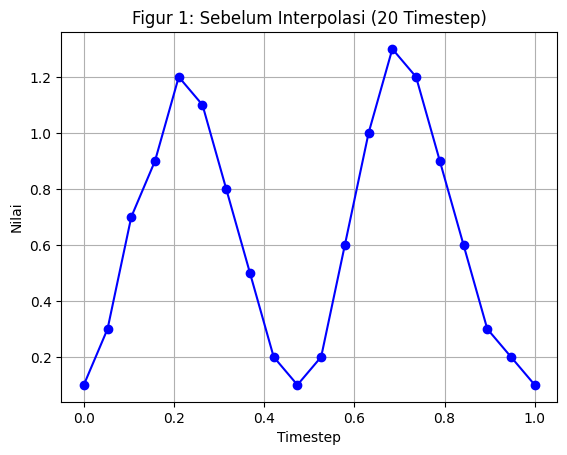

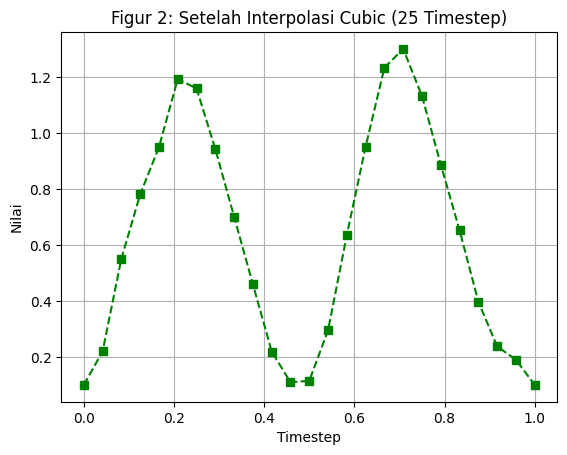

In [ ]:
# Figur 1: Sebelum Interpolasi (20 Data)
plt.figure()
plt.plot(x_20, y_20, 'o-', color='blue')
plt.title('Figur 1: Sebelum Interpolasi (20 Timestep)')
plt.xlabel('Timestep')
plt.ylabel('Nilai')
plt.grid(True)

# Figur 2: Setelah Interpolasi (25 Data) - Cubic
plt.figure()
plt.plot(x_25, y_25_cubic, 's--', color='green')
plt.title('Figur 2: Setelah Interpolasi Cubic (25 Timestep)')
plt.xlabel('Timestep')
plt.ylabel('Nilai')
plt.grid(True)

plt.show()


In [ ]:
import time

# Mulai timer
print("Mulai menghitung detik...")
start = time.time()

try:
    while True:
        elapsed = float(time.time() - start)
        print(f"Sudah berlalu: {elapsed} detik", end='\r')  # menimpa baris yang sama
        time.sleep(1)
except KeyboardInterrupt:
    print("\nTimer dihentikan.")


Mulai menghitung detik...
Sudah berlalu: 14.003652095794678 detiktik
Timer dihentikan.
